In [36]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import pickle

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 1000)
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.model_selection import ShuffleSplit
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import scale

# import tensorflow as tf
# from keras.backend.tensorflow_backend import set_session
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.4
# set_session(tf.Session(config=config))

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, GaussianNoise, Conv1D , GRU
from tensorflow.keras.layers import Dropout, Concatenate, Flatten, Activation, TimeDistributed, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Input, Dense, LSTM, multiply, concatenate, Activation, Masking, Reshape
from tensorflow.keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, RepeatVector, Dropout
from tensorflow.python.keras.utils import plot_model
from tensorflow.keras.losses import MSE
from tqdm import tqdm

import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

def MAE(y_te, pred):
    return np.round(mean_absolute_error(y_te, pred), decimals=4)
    
def RMSE(y_te, pred):
    return np.round(mean_squared_error(y_te, pred)**(1/2), decimals=4)
    
def ME(y_te, pred):
    return np.round((y_te-pred).mean(), decimals=4)

def evaluate(y_te, pred):
    print("mae: {:.4f}".format(mean_absolute_error(y_te, pred)))
    print("rmse: {:.4f}".format(mean_squared_error(y_te, pred)**(1/2)))
    print("me: {:.4f}".format((y_te-pred).mean()))

seed = 0

In [2]:
target_var = ['Target_Hb']

info_vars = ['Study_Subject_Number', 'Order']

categoryA = ["Hemoglobin[Whole blood]", "Delta_Hb", "RDW[Whole blood]", "MCV[Whole blood]", "MCH[Whole blood]", "MCHC[Whole blood]", "Serum Iron[Serum]", "Age (yrs)", "Sex_M", "Sex_F", 'EPO_Dose']

categoryB = ["URR[Serum]", 'Dry Weight', 'Albumin[Serum]', 'Predialysis Weight', 'Height (cm)']

trn_vars = categoryA + categoryB

all_vars = info_vars + trn_vars + target_var

In [3]:
with open('./scaler/trn_scaler_mean.pkl','rb') as f:
    trn_scaler_mean = pickle.load(f)
    
with open('./scaler/hb_scaler_mean.pkl','rb') as f:
    hb_scaler_mean = pickle.load(f)

# Variational Recurrent Autoencoder

In [28]:
def get_vae():
    batch_size = 2048
    n_epoch = 250
    intermediate_dim = 1024
    latent_dim = 512
    learning_rate = 0.001
    seed = 0

    # Q(z|X) -- encoder
    inputs = Input(shape=(seq_len, len(trn_vars)), name='input_encoder')
    h_q = GRU(intermediate_dim, return_sequences=True, name='gru_encoder_1')(inputs)
    h_q = GRU(intermediate_dim, return_sequences=False, name='gru_encoder_2')(h_q)
    z_mean = Dense(latent_dim, name='mean_encoder')(h_q)
    z_log_var = Dense(latent_dim, activation='softplus', name='std_encoder')(h_q)

    def sample_z(args):
        z_mean, z_log_var = args
        batch_size = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch_size, dim), mean=0., stddev=1.)
        return z_mean + K.exp(z_log_var/2) * epsilon # mu + var * epsilon

    # Sample z ~ Q(z|X)
    z = Lambda(sample_z, output_shape=(latent_dim), name='z_generator')([z_mean, z_log_var])

    # P(X|z) -- decoder
    decoder_h = GRU(intermediate_dim, return_sequences=True, name='gru_decoder_1')
    decoder_mean = GRU(len(trn_vars), return_sequences=True, activation=None, name='output_decoder') 

    h_p = RepeatVector(seq_len)(z)
    h_p = decoder_h(h_p)
    x_decoder_mean = decoder_mean(h_p)

    # Overall VAE model, for reconstruction and training
    vae = Model(inputs, x_decoder_mean)

    # encoder, from inputs to latent space
    encoder = Model(inputs, [z_mean, z_log_var, z])

    # Generator model, generate new data given latent variable z
    d_in = Input(shape=(latent_dim,))
    d_h = RepeatVector(seq_len)(d_in)
    d_h = decoder_h(d_h)
    d_out = decoder_mean(d_h)
    decoder = Model(d_in, d_out)

    def vae_loss(x, x_decoder_mean):
        recon = MSE(x, x_decoder_mean)
        kl = - 0.5 * K.mean(1 + z_log_var - K.exp(z_log_var) - K.square(z_mean))
        return recon + kl

    vae.compile(optimizer='adam', loss=vae_loss)
    
    return vae, encoder, decoder

In [35]:
# for s in [2,3,4,5,6,7]:
#     seq_len = s
#     with open('./data/mean_{}.pkl'.format(seq_len),'rb') as f:
#         loaded_data = pickle.load(f)
#     [[x_train,y_train,train_info],[x_valid,y_valid,valid_info],[x_test,y_test,test_info]] = loaded_data

#     vae, encoder, decoder = get_vae()

#     checkpoint = ModelCheckpoint('./vae/vae_v1_{}.h5'.format(seq_len), save_best_only=True, verbose=0)

#     # plot_model(vae, show_shapes=True)

#     hist = vae.fit(x_train, x_train,
#                     callbacks=[checkpoint],
#                     validation_data=(x_valid, x_valid),
#                     batch_size=batch_size,
#                     epochs=n_epoch, verbose=0)

#     plt.plot(hist.history["loss"])
#     plt.plot(hist.history["val_loss"])
#     plt.show()

#     vae.load_weights('./vae/vae_v1_{}.h5'.format(seq_len))

#     print('Seq', seq_len)
#     print('train:', MAE(np.reshape(x_train, (x_train.shape[0], -1)), np.reshape(vae.predict(x_train), (x_train.shape[0], -1))))
#     print('valid:', MAE(np.reshape(x_valid, (x_valid.shape[0], -1)), np.reshape(vae.predict(x_valid), (x_valid.shape[0], -1))))
#     print('test:', MAE(np.reshape(x_test, (x_test.shape[0], -1)), np.reshape(vae.predict(x_test), (x_test.shape[0], -1))))
#     print()

In [39]:
seq_len = 7
with open('./data/mean_{}.pkl'.format(seq_len),'rb') as f:
    loaded_data = pickle.load(f)
[[x_train,y_train,train_info],[x_valid,y_valid,valid_info],[x_test,y_test,test_info]] = loaded_data

vae, encoder, decoder = get_vae()

checkpoint = ModelCheckpoint('./vae/vae_v1_{}.h5'.format(seq_len), save_best_only=True, verbose=0)

# plot_model(vae, show_shapes=True)

hist = vae.fit(x_train, x_train,
               callbacks=[checkpoint],
               validation_data=(x_valid, x_valid),
               batch_size=batch_size,
               epochs=n_epoch, verbose=0)

plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.show()

vae.load_weights('./vae/vae_v1_{}.h5'.format(seq_len))

print('Seq', seq_len)
print('train:', MAE(np.reshape(x_train, (x_train.shape[0], -1)), np.reshape(vae.predict(x_train), (x_train.shape[0], -1))))
print('valid:', MAE(np.reshape(x_valid, (x_valid.shape[0], -1)), np.reshape(vae.predict(x_valid), (x_valid.shape[0], -1))))
print('test:', MAE(np.reshape(x_test, (x_test.shape[0], -1)), np.reshape(vae.predict(x_test), (x_test.shape[0], -1))))
print()

Seq 7
train: 0.3085
valid: 0.34
test: 0.345



In [ ]:
# train: 0.3019
# valid: 0.3445
# test: 0.3416

# Latent Space

In [40]:
z_mean_test, z_std_test, z_test = encoder.predict(x_test, batch_size=batch_size)
# plt.figure(figsize=(6, 6))
# plt.scatter(z_test[:, 0], z_test[:, 1], alpha=.4, s=3**2, cmap='viridis')
# plt.colorbar()
# plt.show()

In [41]:
z_mean_test.shape

(1353, 512)

# Generation

In [42]:
desired_batch_size = 5000
latnet_z = np.random.normal(size=(desired_batch_size, latent_dim))
generated_patient_data = decoder.predict(latnet_z)
generated_x = generated_patient_data[:,:6,:]
generated_y = np.reshape(generated_patient_data[:,-1,0], (-1,1))

# Linear Regression

In [ ]:
for s in [6]:
    seq_len = s
    
    with open('./data/mean_{}.pkl'.format(seq_len),'rb') as f:
        loaded_data = pickle.load(f)
    [[x_train,y_train,_],[x_valid,y_valid,_],[x_test,y_test,_]] = loaded_data
    
    X = np.concatenate([x_train, x_valid, generated_x])
    Y = np.concatenate([y_train, y_valid, generated_y])
    
    models = []
    
    mae_train = []
    rmse_train = []
    me_train = []
    
    mae_valid = []
    rmse_valid = []
    me_valid = []    
    kf = KFold(n_splits=5, random_state=seed)
    for train, valid in kf.split(X):

        x_train_data = np.reshape(X[train],[-1,seq_len*len(trn_vars)])
        y_train_data = Y[train]
               
        x_valid_data = np.reshape(X[valid],[-1,seq_len*len(trn_vars)])
        y_valid_data = Y[valid]

        clf = linear_model.LinearRegression()
        clf.fit(x_train_data, y_train_data)
        
        models.append(clf)        
        
        y_train_pred = hb_scaler_mean.inverse_transform(clf.predict(x_train_data))
        y_valid_pred = hb_scaler_mean.inverse_transform(clf.predict(x_valid_data))
        y_train_data = hb_scaler_mean.inverse_transform(y_train_data)
        y_valid_data = hb_scaler_mean.inverse_transform(y_valid_data)        
        
        mae_train.append(MAE(y_train_data, y_train_pred))
        rmse_train.append(RMSE(y_train_data, y_train_pred))
        me_train.append(ME(y_train_data, y_train_pred))

        mae_valid.append(MAE(y_valid_data, y_valid_pred))
        rmse_valid.append(RMSE(y_valid_data, y_valid_pred))
        me_valid.append(ME(y_valid_data, y_valid_pred))
    
    #######################################################
    
    print('seq : {}'.format(seq_len))
    
    print('train')
    print('mae:', np.mean(mae_train, axis=0).round(4))
    print('rmse:', np.mean(rmse_train, axis=0).round(4))
    print('me:', np.mean(me_train, axis=0).round(4))

    print('valid')
    print('mae:', np.mean(mae_valid, axis=0).round(4))
    print('rmse:', np.mean(rmse_valid, axis=0).round(4))
    print('me:', np.mean(me_valid, axis=0).round(4))

    print('test')
    x_test = np.reshape(x_test,[-1,seq_len*len(trn_vars)])
    test_preds = []
    for model in models:
        test_preds.append(model.predict(x_test))
    y_test = hb_scaler_mean.inverse_transform(y_test)
    pred_test = hb_scaler_mean.inverse_transform(np.mean(test_preds, axis=0))
    evaluate(y_test, pred_test)
    
    print()
    print()

In [ ]:
# seq : 6
# train
# mae: 0.5013
# rmse: 0.6646
# me: 0.0

# valid
# mae: 0.5087
# rmse: 0.6596
# me: 0.0017

# test
# mae: 0.6207
# rmse: 0.8071
# me: 0.0096

# MLP

In [12]:
def mlp_model(i,j):
    K.clear_session()
    np.random.seed(seed)
    inp = Input(shape=(seq_len*len(trn_vars),))
    fc = Dense(i, activation='relu')(inp)
    fc = Dense(j, activation='relu')(fc)
    outp = Dense(1)(fc)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='mean_absolute_error', 
              optimizer=Adam(learning_rate),
              metrics=['mean_absolute_error'])
    return model

In [30]:
learning_rate = 0.001
batch_size = 2048
epoch = 50

for s in [6]:
    seq_len = s
    
    with open('./data/mean_{}.pkl'.format(seq_len),'rb') as f:
        loaded_data = pickle.load(f)
    [[x_train,y_train,_],[x_valid,y_valid,_],[x_test,y_test,_]] = loaded_data
    
    x_train, x_valid, y_train, y_valid = train_test_split(np.concatenate([x_train, x_valid, generated_x]), 
                                                          np.concatenate([y_train, y_valid, generated_y]),
                                                          test_size=0.2, random_state=seed)
                                                          
    models = []
    param = []
    
    mae_train = []
    rmse_train = []
    me_train = []
    
    mae_valid = []
    rmse_valid = []
    me_valid = []   
       
    for i in np.array([2])**list(range(1,11)):
        print('first hidden:', i)
        for j in np.array([2])**list(range(1,11)):
            print('second hidden:', j)
            param.append((i,j))

            x_train_data = np.reshape(x_train,[-1,seq_len*len(trn_vars)])
            y_train_data = y_train

            x_valid_data = np.reshape(x_valid,[-1,seq_len*len(trn_vars)])
            y_valid_data = y_valid

            model = mlp_model(i,j)

            checkpoint = ModelCheckpoint('./temp_models/mean_mlp_'+'_'+str(i)+'_'+str(j)+'_{}.h5'.format(seq_len), save_best_only=True, verbose=0)

            hist = model.fit(x_train_data, y_train_data,
                             callbacks=[checkpoint],
                             validation_data=(x_valid_data, y_valid_data),
                             epochs=epoch, verbose=0, batch_size=batch_size)


            y_train_pred = hb_scaler_mean.inverse_transform(model.predict(x_train_data))
            y_valid_pred = hb_scaler_mean.inverse_transform(model.predict(x_valid_data))
            y_train_data = hb_scaler_mean.inverse_transform(y_train_data)
            y_valid_data = hb_scaler_mean.inverse_transform(y_valid_data)                

            mae_train.append(MAE(y_train_data, y_train_pred))
            rmse_train.append(RMSE(y_train_data, y_train_pred))
            me_train.append(ME(y_train_data, y_train_pred))

            mae_valid.append(MAE(y_valid_data, y_valid_pred))
            rmse_valid.append(RMSE(y_valid_data, y_valid_pred))
            me_valid.append(ME(y_valid_data, y_valid_pred))                
                
            models.append(model)
    
    ###############################################################################
    
    print('seq : {}'.format(seq_len))
    best_param_idx = np.argmin(mae_valid)
    i, j = param[best_param_idx]
    print('best result at:', param[best_param_idx])
    
    print('train')
    print('mae:', mae_train[best_param_idx])
    print('rmse:', rmse_train[best_param_idx])
    print('me:', me_train[best_param_idx])

    print('valid')
    print('mae:', mae_valid[best_param_idx])
    print('rmse:', rmse_valid[best_param_idx])
    print('me:', me_valid[best_param_idx])

    print('test')
    x_test = np.reshape(x_test,[-1,seq_len*len(trn_vars)])
    test_preds = []
    model = models[best_param_idx]
    model.load_weights('./temp_models/mean_mlp_'+'_'+str(i)+'_'+str(j)+'_{}.h5'.format(seq_len))
    y_test = hb_scaler_mean.inverse_transform(y_test)
    pred_test = hb_scaler_mean.inverse_transform(model.predict(x_test))
    evaluate(y_test, pred_test)     
    
    print()
    print()

# GRU

In [43]:
learning_rate = 0.001
epochs = 300
batch_size = 2048
seed = 0
sequences = [2,3,4,5,6]

def get_model():
    K.clear_session()
    np.random.seed(seed)
    inp = Input(shape=(seq_len, len(trn_vars)))
    layer1 = GRU(256, return_sequences=True,
                recurrent_activation='hard_sigmoid',
                activation='tanh')(inp)
    layer2 = GRU(64, return_sequences=False,
                recurrent_activation='hard_sigmoid',
                activation='tanh')(layer1)
    fc = Dense(4)(layer2)
    outp = Dense(1)(fc)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss = 'mean_absolute_error', 
                  optimizer=Adam(learning_rate),
                  metrics=['mean_absolute_error'])
    return model


for s in tqdm(sequences) :
    seq_len = s

    with open('./data/mean_{}.pkl'.format(seq_len),'rb') as f:
        loaded_data = pickle.load(f)
    [[x_train,y_train,_],[x_valid,y_valid,_],[x_test,y_test,_]] = loaded_data
    
    ##
#     vae, encoder, decoder = get_vae()
#     vae.load_weights('./vae/vae_v1_{}.h5'.format(seq_len+1))

#     desired_batch_size = 10000
#     latnet_z = np.random.normal(size=(desired_batch_size, latent_dim))
#     generated_patient_data = decoder.predict(latnet_z)
#     generated_x = generated_patient_data[:,:seq_len,:]
#     generated_y = np.reshape(generated_patient_data[:,-1,0], (-1,1))

#     x_train = np.concatenate([x_train, generated_x])
#     y_train = np.concatenate([y_train, generated_y])
    ##
    
#     x_train, x_valid, y_train, y_valid = train_test_split(np.concatenate([x_train, x_valid, generated_x]), 
#                                                           np.concatenate([y_train, y_valid, generated_y]),
#                                                           test_size=0.2, random_state=seed)

    model = get_model()

    checkpoint = ModelCheckpoint('./temp_models/gru_mean_wo_gauss{}.h5'.format(seq_len), save_best_only=True, verbose=0)

    hist = model.fit(np.array(x_train), np.array(y_train), 
                     callbacks=[checkpoint],
                     validation_data=(np.array(x_valid), np.array(y_valid)), 
                     batch_size=batch_size, epochs=epochs, verbose=0) 

    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.show()

    model.load_weights('./temp_models/gru_mean_wo_gauss{}.h5'.format(seq_len))

    print(seq_len)
    pred_train = model.predict(x_train)
    print('train')
    y_train = hb_scaler_mean.inverse_transform(y_train)
    pred_train = hb_scaler_mean.inverse_transform(pred_train)
    evaluate(y_train, pred_train)

    pred_valid = model.predict(x_valid)
    print('val')
    y_valid = hb_scaler_mean.inverse_transform(y_valid)
    pred_valid = hb_scaler_mean.inverse_transform(pred_valid)
    evaluate(y_valid, pred_valid)

    pred_test = model.predict(x_test)
    print('test')
    y_test = hb_scaler_mean.inverse_transform(y_test)
    pred_test = hb_scaler_mean.inverse_transform(pred_test)
    evaluate(y_test, pred_test)

    print()
    print()

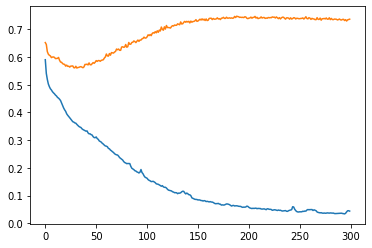

6
train
mae: 0.3838
rmse: 0.5956
me: -0.0006
val
mae: 0.6086
rmse: 0.7883
me: 0.0118
test
mae: 0.6099
rmse: 0.7968
me: -0.0227




In [44]:
learning_rate = 0.001
epochs = 100
batch_size = 2048
seed = 0
sequences = [2,3,4,5,6]

def get_model():
    K.clear_session()
    np.random.seed(seed)
    inp = Input(shape=(seq_len, len(trn_vars)))
    layer1 = GRU(256, return_sequences=True,
                recurrent_activation='hard_sigmoid',
                activation='tanh')(inp)
    layer2 = GRU(64, return_sequences=False,
                recurrent_activation='hard_sigmoid',
                activation='tanh')(layer1)
    fc = Dense(4)(layer2)
    outp = Dense(1)(fc)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss = 'mean_absolute_error', 
                  optimizer=Adam(learning_rate),
                  metrics=['mean_absolute_error'])
    return model


seq_len = 6

with open('./data/mean_{}.pkl'.format(seq_len),'rb') as f:
    loaded_data = pickle.load(f)
[[x_train,y_train,_],[x_valid,y_valid,_],[x_test,y_test,_]] = loaded_data

vae, encoder, decoder = get_vae()
vae.load_weights('./vae/vae_v1_{}.h5'.format(seq_len+1))
desired_batch_size = 5000
latnet_z = np.random.normal(size=(desired_batch_size, latent_dim))
generated_patient_data = decoder.predict(latnet_z)
generated_x = generated_patient_data[:,:seq_len,:]
generated_y = np.reshape(generated_patient_data[:,-1,0], (-1,1))

x_train = np.concatenate([x_train, generated_x])
y_train = np.concatenate([y_train, generated_y])

model = get_model()

checkpoint = ModelCheckpoint('./temp_models/gru_mean_wo_gauss{}.h5'.format(seq_len), save_best_only=True, verbose=0)

hist = model.fit(x_train, y_train, 
                 callbacks=[checkpoint],
                 validation_data=(np.array(x_valid), np.array(y_valid)), 
                 batch_size=batch_size, epochs=epochs, verbose=0) 

plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.show()

model.load_weights('./temp_models/gru_mean_wo_gauss{}.h5'.format(seq_len))

print(seq_len)
pred_train = model.predict(x_train)
print('train')
y_train = hb_scaler_mean.inverse_transform(y_train)
pred_train = hb_scaler_mean.inverse_transform(pred_train)
evaluate(y_train, pred_train)

pred_valid = model.predict(x_valid)
print('val')
y_valid = hb_scaler_mean.inverse_transform(y_valid)
pred_valid = hb_scaler_mean.inverse_transform(pred_valid)
evaluate(y_valid, pred_valid)

pred_test = model.predict(x_test)
print('test')
y_test = hb_scaler_mean.inverse_transform(y_test)
pred_test = hb_scaler_mean.inverse_transform(pred_test)
evaluate(y_test, pred_test)

print()
print()

In [ ]:
# 6
# train
# mae: 0.4250
# rmse: 0.5899
# me: -0.0096
# val
# mae: 0.5846
# rmse: 0.7675
# me: -0.0162
# test
# mae: 0.6086
# rmse: 0.7936
# me: 0.0034

# GRU with Gaussian Noise

In [31]:
learning_rate = 0.001
epochs = 100
batch_size = 2048 
seed = 0
sequences = [2,3,4,5,6]

def get_model():        
    K.clear_session()
    np.random.seed(seed)
    inp = Input(shape=(seq_len, len(trn_vars)))
    gauss1 = GaussianNoise(0.1)(inp)
    layer1 = GRU(256, return_sequences=True,
                recurrent_activation='hard_sigmoid',
                activation='tanh')(gauss1)
    layer2 = GRU(64, return_sequences=False,
                recurrent_activation='hard_sigmoid',
                activation='tanh')(layer1)   
    fc = Dense(4)(layer2)
    outp = Dense(1)(fc)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss = 'mean_absolute_error', 
                  optimizer=Adam(learning_rate),
                  metrics=['mean_absolute_error'])
    return model


for s in tqdm([6]) :
    seq_len = s
    
    with open('./data/mean_{}.pkl'.format(seq_len),'rb') as f:
        loaded_data = pickle.load(f)
    [[x_train,y_train,_],[x_valid,y_valid,_],[x_test,y_test,_]] = loaded_data
    
    x_train, x_valid, y_train, y_valid = train_test_split(np.concatenate([x_train, x_valid, generated_x]), 
                                                          np.concatenate([y_train, y_valid, generated_y]),
                                                          test_size=0.2, random_state=seed)
    
    model = get_model()
    
    checkpoint = ModelCheckpoint('./temp_models/gru_mean_{}.h5'.format(seq_len), save_best_only=True, verbose=0)

    hist = model.fit(np.array(x_train), np.array(y_train), 
                     callbacks=[checkpoint],
                     validation_data=(np.array(x_valid), np.array(y_valid)), 
                     batch_size=batch_size, epochs=epochs, verbose=0) 

    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.show()

    model.load_weights('./temp_models/gru_mean_{}.h5'.format(seq_len))
    
    print(seq_len)
    pred_train = model.predict(x_train)
    print('train')
    y_train = hb_scaler_mean.inverse_transform(y_train)
    pred_train = hb_scaler_mean.inverse_transform(pred_train)
    evaluate(y_train, pred_train)

    pred_valid = model.predict(x_valid)
    print('val')
    y_valid = hb_scaler_mean.inverse_transform(y_valid)
    pred_valid = hb_scaler_mean.inverse_transform(pred_valid)
    evaluate(y_valid, pred_valid)

    pred_test = model.predict(x_test)
    print('test')
    y_test = hb_scaler_mean.inverse_transform(y_test)
    pred_test = hb_scaler_mean.inverse_transform(pred_test)
    evaluate(y_test, pred_test)
    
    print()
    print()

# Performance by Hospital

In [ ]:
seq_len = 6
learning_rate = 0.001
epochs = 100
batch_size = 2048 
seed = 0

def get_model():        
    K.clear_session()
    np.random.seed(seed)
    inp = Input(shape=(seq_len, len(trn_vars)))
    gauss1 = GaussianNoise(0.1)(inp)
    layer1 = GRU(256, return_sequences=True,
                recurrent_activation='hard_sigmoid',
                activation='tanh')(gauss1)
    layer2 = GRU(64, return_sequences=False,
                recurrent_activation='hard_sigmoid',
                activation='tanh')(layer1)   
    fc = Dense(4)(layer2)
    outp = Dense(1)(fc)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss = 'mean_absolute_error', 
                  optimizer=Adam(learning_rate),
                  metrics=['mean_absolute_error'])
    return model

model = get_model()
model.load_weights('./temp_models/gru_mean_{}.h5'.format(seq_len))

with open('./data/mean_{}.pkl'.format(seq_len),'rb') as f:
    loaded_data = pickle.load(f)
[[x_train,y_train,train_info],[x_valid,y_valid,valid_info],[x_test,y_test,test_info]] = loaded_data

In [ ]:
train_info = np.array([i[0] for i in train_info[:,0]])
valid_info = np.array([i[0] for i in valid_info[:,0]])
test_info = np.array([i[0] for i in test_info[:,0]])

In [ ]:
for h in ['A', 'B', 'D', 'E', 'F', 'G', 'H']:
    print('Hospital:', h)
    
    pred_train = model.predict(x_train[train_info==h])
    print('train')
    pred_train = hb_scaler_mean.inverse_transform(pred_train)
    print('mae:', MAE(hb_scaler_mean.inverse_transform(y_train[train_info==h]), pred_train))

    pred_valid = model.predict(x_valid[valid_info==h])
    print('val')
    pred_valid = hb_scaler_mean.inverse_transform(pred_valid)
    print('mae:', MAE(hb_scaler_mean.inverse_transform(y_valid[valid_info==h]), pred_valid))

    pred_test = model.predict(x_test[test_info==h])
    print('test')
    pred_test = hb_scaler_mean.inverse_transform(pred_test)
    print('mae:', MAE(hb_scaler_mean.inverse_transform(y_test[test_info==h]), pred_test))

    print()
    print()    